In [2]:
import datetime as dt
import os
import math as m

import eb

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

In [71]:
##### USER INPUTS #####
ex = False

#figsize
b = eb.inch(21)
w = eb.inch(29.7)
DIN_A4 = (eb.inch(21),eb.inch(29.7))
DIN_A3 = (eb.inch(2*21),eb.inch(29.7))

#legendlocation
y = 0

#fontsizes
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 11

#plt.rc("figure", figsize=DIN_A3)
plt.rc("figure", titlesize=BIGGER_SIZE)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes

plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title

plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('lines', linewidth = 0.5)

plt.rc('axes.spines', left=False)
plt.rc('axes.spines', right=False)
plt.rc('axes.spines', top=False)
plt.rc('axes.spines', bottom=False)

plt.rc('legend', frameon=False)

In [5]:
amb = eb.load_amb(eb.files['tf']['WD']['1min'])

In [ ]:
for bui in ['MH']:
    ind = eb.load_bui(eb.files['tf'][bui]['1min'])
    ind = ind.loc['01-June-2021':]
    amb = amb.loc['01-June-2021':]
    print('---plotting {}---'.format(eb.buid[bui]))
    for app in ['N']: #eb.wohnungen:
        print('------plotting Wohnung {}------'.format(eb.wohnungen[app]))
        for room in eb.rooms:
            if room in ind[app].columns.get_level_values(level=0).unique():
                print('------plotting {}------'.format(eb.rooms[room]))
                #define figure
                mpl.use('pdf')
                fig = plt.figure(figsize=DIN_A4,constrained_layout=True)
                gs = GridSpec(10, 2, figure=fig)
                axs=[]
                i=0
                l=0
                fig.suptitle('Einfach Bauen Häuser - Bad Aibling\nAuswertung Messdaten\n{} | Wohnung {} | {}\n'.format(eb.buid[bui],eb.wohnungen[app],eb.rooms[room]), fontweight = 'bold')

                #----#1: Temperature ----
                sensor = 'trh_Tair'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    #print('Plot {}: Temperature'.format(i+1))
                    if len(df.columns) > 1:
                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                        df.drop(df.columns[1],axis=1,inplace=True)
                    df.columns = ['Tair']

                    Tair = df

                    TAMBG24 = amb['T_amb'].rolling('D').mean()
                    Tamb = amb['T_amb']

                    axs.append(fig.add_subplot(gs[l,:]))

                    axs[i].plot(df.resample('15min').last(),label = 'Raumlufttemperatur',alpha=0.75)
                    axs[i].plot(Tamb.resample('15min').last(),label = 'Außenlufttemperatur',alpha=0.75)

                    sensor = 'pt_Tsk'
                    df = ind[app][room].filter(like=sensor)
                    if len(df.columns) > 0:
                        axs[i].plot(df,label = 'Globethermometer',alpha=0.75)

                    eb.recolor_lines(axs[i], eb.c_temp)

                    axs[i].set_title('Temperaturen', fontweight = 'bold')
                    axs[i].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=1
                else:
                    Tair = None
                    TAMBG24 = None
                    Tamb = None
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#2: Humidity ----
                sensor = 'trh_RH'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    #print('Plot {}: Humidity'.format(i+1))
                    if len(df.columns) > 1:
                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                        df.drop(df.columns[1],axis=1,inplace=True)
                    df.columns = ['Rh']

                    Rh = df.replace([' ',''],np.NAN)
                    Rh_amb = amb.Rh_amb

                    axs.append(fig.add_subplot(gs[l, :]))
                    axs[i].plot(Rh.resample('H').last(),label = 'Raumluftfeuchte',alpha=0.75)
                    axs[i].plot(Rh_amb.resample('H').last(),label = 'Außenluftfeuchte',alpha=0.75)
                    eb.recolor_lines(axs[i], eb.c_hum)

                    axs[i].set_title('Luftfeuchten', fontweight = 'bold')
                    axs[i].set_ylabel('rel. Luftfeuchte\n[%]', fontweight = 'bold')
                    axs[i].set_ylim(0,100)
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=1
                else:
                    Rh=''
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#3: Heizkörpertemperatur ----
                sensor = 'pt_Thk'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    axs.append(fig.add_subplot(gs[l,:]))
                    axs[i].plot(df.resample('H').last(),label = eb.get_labels(df),alpha=0.75)
                    eb.recolor_lines(axs[i], eb.c_temp)

                    axs[i].set_title('Heizkörpertemperaturen', fontweight = 'bold')
                    axs[i].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')
                    axs[i].set_ylim(0,55)
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=1
                else:
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#4: Bewegungsmelder ----
                sensor = '_md'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    df.columns = ['md']
                    axs.append(fig.add_subplot(gs[l,:]))
                    axs[i].plot(df.resample('H').sum(),label = 'Bewegungsmelder (stündliche Summe)',alpha=0.75)
                    axs[i].plot(df.resample('D').sum(),label = 'Bewegungsmelder (tägliche Summe)',alpha=0.75, ls='dashed')
                    eb.recolor_lines(axs[i], 'Purples_r' ,minint=0 ,maxint=0.8)

                    axs[i].set_title('Bewegungsmelder', fontweight = 'bold')
                    axs[i].set_ylabel('Anwesenheit\n[min pro Stunde/Tag]', fontweight = 'bold')
                    axs[i].legend(loc=y, frameon=True)
                    i+=1
                    l+=1
                else:
                    axs.append(fig.add_subplot(gs[l,:]))
                    axs[i].text(0.5,0.5,f'no {sensor} sensor in room {eb.rooms[room]}')
                    i+=1
                    l+=1
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#5: CO2 ----
                sensor = 'co2'
                if len(ind[app][room].filter(like=sensor).columns) == 0:
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))
                else: 
                    sensors = list(ind[app][room].filter(like=sensor).columns)
                    for sensor in sensors:
                        if sensor.count('_') == 1:
                            sensors = sensor

                    axs.append(fig.add_subplot(gs[l, :]))

                    axs[i].plot(ind[app][room][sensors].rolling('24H').mean(),label = 'CO2_mean (24h)',alpha=0.75,ls='dashed')
                    axs[i].plot(ind[app][room][sensors],label = 'CO2',alpha=0.75)

                    eb.recolor_lines(axs[i], eb.c_co2)

                    axs[i].set_title('CO2 Konzentration in der Raumluft', fontweight = 'bold')
                    axs[i].set_ylabel('CO2 Konzentration\n[ppm]', fontweight = 'bold')
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=1

                #----#6: Windows ----
                windows = ind[app][room].filter(like='reed')
                if len(windows.columns) > 0:
                    #print('Plot {}: Windows'.format(i+1))
                    axs.append(fig.add_subplot(gs[l, :]))
                    for window in windows.columns.str.split(' ',expand=True).droplevel(level=1).unique():
                        if len(windows.filter(like=window).columns) > 1:
                            windows.iloc[:,1] = windows.filter(like=window).iloc[:,1].fillna(windows.filter(like=window).iloc[:,0])
                            windows.drop(windows.filter(like=window).iloc[:,0].name,axis=1,inplace=True)
                    windows.replace(['Closed','Open'],[0,1],inplace=True)

                    axs[i].plot(windows.resample('D').sum(), label=eb.get_labels(windows),alpha=0.75, ls='dashed')
                    
                    axs.append(axs[i].twinx())

                    for w,col in enumerate(windows.columns):
                        norm = mpl.colors.Normalize(vmin=0, vmax=len(windows.columns))
                        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
                        cmap.set_array([])

                        axs[i+1].fill_between(x=windows.index, y1=windows[col], label=col,color=cmap.to_rgba(w + 1), alpha=0.2)

                    eb.recolor_lines(axs[i], 'Oranges_r', minint=0,maxint=0.5)
                    axs[i].set_title('Lüftungsverhalten', fontweight = 'bold')
                    axs[i].set_ylabel('Fensteröffnung\n[min pro Tag]', fontweight = 'bold')

                    axs[i].legend(loc=2, frameon=False)
                    axs[i+1].legend(loc=2, frameon=False)
                    axs[i+1].set_yticks([0,1])
                    axs[i+1].set_yticklabels(['Geschlossen','Geöffnet'])
                    axs[i+1].tick_params(axis = 'y', which='major', length=0)
                    l+=1
                    i+=2
                else:
                    print('{}: Keine Fenster vorhanden'.format(room))


                for ax in axs:
                    ax.set_xlim(min(ind.index.min(),amb.index.min()),max(ind.index.max(),amb.index.max()))

                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

                    locator = mdates.MonthLocator()

                    ax.xaxis.set_major_locator(locator)


                #----#7.1: Thermal Comfort ----

                if isinstance(Tair,(pd.Series, pd.DataFrame)) and isinstance(TAMBG24,(pd.Series, pd.DataFrame)):

                    axs.append(fig.add_subplot(gs[l:l+4, 1]))
                    eb.thermal_comfort_2(TAMBG24=TAMBG24.resample('H').last(),TOP=Tair.resample('H').last(),axs=axs[i])


                #----#7.2: H,x - Diagramm ----

                if isinstance(Tair,(pd.Series, pd.DataFrame)) and isinstance(Rh,(pd.Series, pd.DataFrame)):
                    axs.append(fig.add_subplot(gs[l:l+4, 0]))
                    i+=1
                    eb.hx_diagramm(t1=Tair.resample('H').last(),rh1=Rh.resample('H').last(),rh2=Rh_amb.resample('H').last(),t2=Tamb.resample('H').last(),ax=axs[i])
                for ax in axs:
                    for spine in ax.spines:
                        ax.spines[spine].set_visible(False)
                if ex:
                    eb.export(fig,filepath=os.path.join(eb.dir_results,'Übersicht',eb.buid[bui],eb.wohnungen[app]),filename='{}_{}_{}_Übersichtsgrafik'.format(bui,app,room), extlist=['pdf','svg','png'],extsubfolder=True)
print('Done!')

In [ ]:
n_days = 30
n_weeks = 15

def timespan(df, days = 0, weeks = None, start=None, end=None):
    last_day = df.index.max().date()
    if isinstance(end,dt.date):
        last_day=end
    weekday = last_day.weekday()
    if isinstance(weeks, int):
        days = weeks*7
    start_day = last_day - dt.timedelta(days = days)
    if isinstance(start,dt.date):
        start_day = start
    df = df.loc[start_day:last_day]
    return df

pm = eb.load_pm(eb.files['tf']['PM']['1min'])
amb = eb.load_amb(eb.files['tf']['WD']['1min'])

if isinstance(n_days,int) or isinstance(n_weeks,int):
    pm = timespan(pm,days=n_days,weeks=n_weeks)
    amb = timespan(amb,days=n_days,weeks=n_weeks)

weekday = max(amb.index.max().date().weekday(),pm.index.max().date().weekday())
n_days = abs(max((amb.index.min()-amb.index.max()).days,(pm.index.min()-pm.index.max()).days))


fig = plt.figure(figsize=(b,b*m.sqrt(2)),constrained_layout=True)
fig.suptitle('Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\n', fontweight = 'bold', size=fs_head)
gs = GridSpec(5*2, 2, figure=fig)
axs=[]
i=0
l=0
axs.append(fig.add_subplot(gs[l:l+1,:]))
axs[i].set_title('Temperaturen', fontweight = 'bold', size=fs_main)
axs[i].set_ylabel('[°C]')
axs[i].plot(amb.T_amb,alpha=0.5,label='aktuelle Temperatur')
axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
eb.recolor_lines(axs[i], eb.c_temp)
axs[i].legend(loc=2, frameon=False)

i+=1
l+=1
axs.append(fig.add_subplot(gs[l:l+1,:]))
axs[i].set_title('Luftfeuchte', fontweight = 'bold', size=fs_main)
axs[i].set_ylabel('[%]')
axs[i].set_ylim(0,100)
axs[i].plot(amb.Rh_amb,alpha=0.5,label='aktuelle Luftfeuchte')
axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
eb.recolor_lines(axs[i], 'Blues', minint=0.5,maxint=1)
axs[i].legend(loc='lower left', frameon=False)
i+=1
l+=1
axs.append(fig.add_subplot(gs[l:l+1,:]))
axs[i].set_title('Niederschlag', fontweight = 'bold', size=fs_main)
axs[i].set_ylabel('[mm]')
axs[i].plot(amb.rain.diff(),alpha=0.5,label='aktueller Niederschlag')
axs[i].legend(loc=2, frameon=False)
axs.append(axs[i].twinx())
i+=1
axs[i].set_ylabel('[mm/Tag]')
axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
axs[i].legend(loc=1, frameon=False)
i+=1
l+=1
axs.append(fig.add_subplot(gs[l:l+1,:]))
axs[i].set_title('Mittlere Windgeschwindigkeit pro Tag', fontweight = 'bold', size=fs_main)
axs[i].set_ylabel('[m/s]')
axs[i].plot(amb.windspeed.rolling('D').mean(),alpha=1, label = 'Wind')  
axs[i].plot(amb.gustspeed.rolling('D').mean(),alpha=0.75,label = 'Bö',linestyle='dashed')  
eb.recolor_lines(axs[i], 'Greens_r', minint=0.3,maxint=0.7)
axs[i].legend(loc=2, frameon=False)

i+=1
l+=1
axs.append(fig.add_subplot(gs[l:l+1,:]))
axs[i].set_title('Mittlere Sonneneinstrahlung pro Tag', fontweight = 'bold', size=fs_main)
axs[i].set_ylabel('[kWh/m²]')
df_p=pm.resample('H').sum().resample('D').mean()/1000

axs[i].bar(df_p.index,df_p['global'],label='global',color=plt.cm.Accent(0))
axs[i].bar(df_p.index,df_p['direct'],bottom = df_p['global'], label='direct',color=plt.cm.Accent(0.5))
axs[i].bar(df_p.index,df_p['diffuse'],bottom = df_p['direct'], label='diffuse',color=plt.cm.Accent(1))
axs[i].legend(loc=2, frameon=False)

y=amb.resample('H').last().isna().all(axis=1).replace([True,False],[1,0])

for ax in axs:
    if n_days > 60:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if n_days <= 60:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(weekday))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %d.%m'))

    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

if ex:
    eb.export(fig,filepath=os.path.join(eb.dir_results,'Wetterstation'),filename='Wetterdaten', extlist=['pdf','svg','png'])

In [ ]:
winddir = {'E':4, 'ENE':3, 'ESE':5, 'N':0, 'NE':2, 'NNE':1, 'NNW':15, 'NW':14, 'S':8, 'SE':6, 'SSE':7,
       'SSW':9, 'SW':10, 'W':12, 'WNW':13, 'WSW':11}
winddir = dict(sorted(winddir.items(), key=lambda item: item[1]))
wind = dict(zip(winddir.keys(), np.linspace(0,2*np.pi,16,endpoint=False)))

W =  amb.loc[:,['winddir','windspeed','gustspeed']]
W['dir'] = W.winddir.replace(wind)

bins = np.linspace(W.windspeed.min(), W.windspeed.max(), 6)
labels = ['{} - {} m/s'.format(round(bins[i-1],1),round(bins[i],1)) for i in range(1,6)]

columns = ['bin{}'.format(i) for i in range(6)]
rose = pd.DataFrame(index=W.winddir.value_counts().index, columns=columns)

for i in range(1,6):
    rose[columns[i]] = W[(W.windspeed > bins[i-1]) & (W.windspeed <= bins[i])].groupby("winddir").size()/W.groupby('winddir').size().sum()
rose = rose*100

rose['theta'] = rose.index
rose.theta.replace(wind,inplace=True)
rose['deg'] =  rose.theta.apply(np.rad2deg)
rose.replace(np.nan,0,inplace=True)

fig, ax = plt.subplots(figsize = (10,10*m.sqrt(2)), subplot_kw={'projection': 'polar'})

ax.set_title('Windrose', fontsize=fs_main+2,fontweight='bold')

w = 2*np.pi/(16)

_colors = plt.cm.Accent(np.linspace(0,1,5))

ax.bar(rose.theta,rose.bin1,width = w, bottom=0, label = labels[0],color=_colors[0],alpha=0.75)
ax.bar(rose.theta,rose.bin2,width = w, bottom=rose.bin1, label = labels[1],color=_colors[1],alpha=0.75)
ax.bar(rose.theta,rose.bin3,width = w, bottom=rose.bin1+rose.bin2, label = labels[2],color=_colors[2],alpha=0.75)
ax.bar(rose.theta,rose.bin4,width = w, bottom=rose.bin1+rose.bin2+rose.bin3, label = labels[3],color=_colors[3],alpha=0.75)
ax.bar(rose.theta,rose.bin5,width = w, bottom=rose.bin1+rose.bin2+rose.bin3+rose.bin4, label = labels[4],color=_colors[4],alpha=0.75)

ax.set_theta_direction(-1)

ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False))
ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False)+0.25*np.pi,minor=True)
ax.set_xticklabels(['NO','SO','SW','NW'],fontsize='small',minor=True)
ax.set_xticklabels(['Nord','Ost','Süd','West'],fontweight='bold')
#ax.set_xticklabels(['N','NO','O','SO','S','SW','W','NW'],fontweight='bold')

ax.set_theta_zero_location('N')

ax.grid(linestyle='dashed')
ax.grid(linestyle='dotted',which='minor')

ax.set_rlabel_position(60)
ax.legend(loc=3)
ax.yaxis.set_major_locator(ticker.FixedLocator([5,10,15,20]))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

fig.tight_layout()

if ex:
    eb.export(fig,filepath=os.path.join(eb.dir_results,'Wetterstation'),filename='Windrose', extlist=['pdf','svg','png'])

In [ ]:
for bui in eb.buid:
    ind = eb.load_bui(eb.files['tf'][bui]['raw'])
    fig,axs=plt.subplots(3,1,figsize=(15,10))
    fig.suptitle(eb.buid[bui],fontweight='bold',fontsize='large')
    for i, app in enumerate(eb.wohnungen):
        df = ind[app]['Strom'].iloc[:,6:9]
        
        df[df < 1.0] = np.NaN
        df.replace(0,np.NaN,inplace=True)
        
        df = df.abs()
        df = df.resample('1min').last().diff()*60

        df2 = ind[app]['Strom'].iloc[:,3:6].abs().replace(0,np.NaN).resample('1min').last()
        df2.columns = df.columns

        df.fillna(df2,inplace=True)
        df.columns = ['Stromkreis {}'.format(i) for i in range(1,4)]
        df = df.resample('H').sum()


        axs[i].set_ylabel('[Wh]')
        axs[i].set_title(eb.wohnungen[app],fontweight='bold',fontsize='medium')
        df.plot(ax=axs[i])

    if ex:
        eb.export(fig,filepath=os.path.join(eb.dir_results,'Stromzähler'),filename=f'{bui}_Übersicht_Stromzähler', extlist=['pdf','svg','png'])

In [ ]:
for bui in eb.buid:
    ind=eb.load_bui(eb.files['tf'][bui]['raw']).loc['2021-06-01':]
    fig = plt.figure(figsize=(15,10),constrained_layout=True)
    gs = GridSpec(3, 4, figure=fig)
    axs=[]

    fig.suptitle('{}'.format(eb.buid[bui]),fontweight='bold',fontsize='large')
    for i, app in enumerate(eb.wohnungen):
        axs.append([])
        dfs = []

        for room in eb.rooms:
            try:
                idx = []
                df = ind[app][room].filter(like='reed')                    
                for window in df.columns.str.split(' ',expand=True).droplevel(level=1).unique():
                    if len(df.filter(like=window).columns) > 1:
                        df.iloc[:,1] = df.filter(like=window).iloc[:,1].fillna(df.filter(like=window).iloc[:,0])
                        df.drop(df.filter(like=window).iloc[:,0].name,axis=1,inplace=True)
                df.replace(['Closed','Open'],[0,1],inplace=True)
                for f,col in enumerate(df.columns):
                    t = col.split(' ')
                    ori = t[0].split('_')[0]
                    idx.append((room,'{}{}_{}'.format(ori,f, t[1])))
                df.columns = pd.MultiIndex.from_tuples(idx)
                dfs.append(df)
            except:
                continue

        df = pd.concat(dfs).resample('1min').max()

        n=len(df.columns)
        df1 = df.sum(axis=1)
        df1 = df1[df1 > 0]
        counts = df1.value_counts(normalize=True)
        gl = round(df1.dropna().mean(),1)
        ventkoeff = round(df.max(axis=1).value_counts(normalize=True)[1.0]*100,1)    #Anteil der Zeit in der Fenster geöffnet sind. Gewichtet nach Anzahl der Fenster.
        
        ### Histogramm
        j=0
        axs[i].append(fig.add_subplot(gs[i, 0]))
        df3 = df.sum(axis=1)
        df3.hist(ax = axs[i][j],bins=np.linspace(0,n+1,n+2), grid = False)
        axs[i][j].set_xticks(np.linspace(0,n,n+1)+0.5)
        axs[i][j].set_xticklabels(range(n+1))
        axs[i][j].set_title('Häufigkeitsverteilung ')
        ###Timeline
        j+=1
        axs[i].append(fig.add_subplot(gs[i, 1:]))
        axs[i][j].set_title('Wohnung {}'.format(eb.wohnungen[app]),fontweight='bold',fontsize='large')
        axs[i][j].text(
                0.0,
                0.95, 
                'Fenster pro Wohnung: {}\nZeit mit min. einem geöffnetem Fenster: {} %\nDurschnittlich gleichzeitig geöffnete Fenster: {}\nMaximal gleichzeitig geöffnete Fenster: {}'.format(n,ventkoeff,gl,int(df1.max())),      
                fontsize = 'large', 
                style='normal', 
                ha = 'left', 
                va = 'top',
                transform=axs[i][j].transAxes,
                bbox=dict(boxstyle="round", fc="w"), 
                )
        axs[i][j].set_ylim(0,24*60*n)
        df2 = df.sum(axis=1).resample('D').sum()
        axs[i][j].bar(df2.index, df2)
        axs[i][j].plot(df2.rolling('30D').mean(),'r--')

    for axj in axs:
        for ax in axj:
            for spine in ax.spines:
                ax.spines[spine].set_visible(False)

    for ax in axs:
        ax[1].xaxis.set_major_locator(mdates.MonthLocator())
        ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if ex:
        eb.export(fig,filepath=os.path.join(eb.dir_results,'Lüftungsverhalten'),filename=f'{bui}_Übersicht', extlist=['pdf','svg','png'])

In [ ]:
for bui in ['MH']: #eb.buid:
    ind = eb.load_bui(eb.files['tf'][bui]['1min'])
    ind = ind.loc['01-June-2021':]
    amb = amb.loc['01-June-2021':]
    print('---plotting {}---'.format(eb.buid[bui]))
    for app in ['N']: #eb.wohnungen:
        print('------plotting Wohnung {}------'.format(eb.wohnungen[app]))
        for room in eb.rooms:
            print('------plotting {}------'.format(eb.rooms[room]))
            
            if room not in ind[app].columns.get_level_values(level=0).unique():
                print('no room {} in {}'.format(eb.rooms[room], eb.wohnungen[app]))
            else:
                #define figure
                fig = plt.figure(figsize=DIN_A4,constrained_layout=True)
                gs = GridSpec(8*2, 2, figure=fig)
                fig_size = plt.rcParams["figure.figsize"]
                fig_size[0] = 11 #fig_size[0] = 11.69
                fig_size[1] = 8 #fig_size[1] = 8.27
                plt.rcParams["figure.figsize"] = fig_size
                axs=[]
                i=0
                l=0

                fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Messdaten\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}\n',fontweight = 'bold')
                #print(list(ind[app][room].columns.unique()))

                #----#1: Temperature ----
                sensor = 'trh_Tair'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    #print('Plot {}: Temperature'.format(i+1))
                    if len(df.columns) > 1:
                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                        df.drop(df.columns[1],axis=1,inplace=True)
                    df.columns = ['Tair']

                    Tair = df

                    TAMBG24 = amb['T_amb'].rolling('D').mean()
                    Tamb = amb['T_amb']
                    axs.append(fig.add_subplot(gs[l:l+2,:]))

                    axs[i].plot(df.resample('15min').last(),label = 'Raumlufttemperatur',alpha=0.75)
                    axs[i].plot(Tamb.resample('15min').last(),label = 'Außenlufttemperatur',alpha=0.75)

                    sensor = 'pt_Tsk'
                    df = ind[app][room].filter(like=sensor)
                    if len(df.columns) > 0:
                        axs[i].plot(df,label = 'Globethermometer',alpha=0.75)

                    eb.recolor_lines(axs[i], eb.c_temp)

                    axs[i].set_title('Temperaturen', fontweight = 'bold')
                    axs[i].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=2
                else:
                    Tair = None
                    TAMBG24 = None
                    Tamb = None
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#2: Humidity ----
                sensor = 'trh_RH'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    #print('Plot {}: Humidity'.format(i+1))
                    if len(df.columns) > 1:
                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                        df.drop(df.columns[1],axis=1,inplace=True)
                    df.columns = ['Rh']

                    Rh = df.replace([' ',''],np.NAN)
                    Rh_amb = amb.Rh_amb

                    axs.append(fig.add_subplot(gs[l:l+2, :]))
                    axs[i].plot(Rh.resample('H').last(),label = 'Raumluftfeuchte',alpha=0.75)
                    axs[i].plot(Rh_amb.resample('H').last(),label = 'Außenluftfeuchte',alpha=0.75)
                    eb.recolor_lines(axs[i], eb.c_hum)

                    axs[i].set_title('Luftfeuchten', fontweight = 'bold')
                    axs[i].set_ylabel('rel. Luftfeuchte\n[%]', fontweight = 'bold')
                    axs[i].set_ylim(0,100)
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=2
                else:
                    Rh=''
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#3: Heizkörpertemperatur ----
                sensor = 'pt_Thk'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    axs.append(fig.add_subplot(gs[l:l+2,:]))
                    axs[i].plot(df.resample('H').last(),label = eb.get_labels(df),alpha=0.75)
                    eb.recolor_lines(axs[i], eb.c_temp)

                    axs[i].set_title('Heizkörpertemperaturen', fontweight = 'bold')
                    axs[i].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')
                    axs[i].set_ylim(0,55)
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=2
                else:
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#4: Bewegungsmelder ----
                sensor = '_md'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    df.columns = ['md']
                    axs.append(fig.add_subplot(gs[l,:]))
                    axs[i].plot(df.resample('H').sum(),label = 'Bewegungsmelder (stündliche Summe)',alpha=0.75)
                    axs[i].plot(df.resample('D').sum(),label = 'Bewegungsmelder (tägliche Summe)',alpha=0.75, ls='dashed')
                    eb.recolor_lines(axs[i], 'Purples_r' ,minint=0 ,maxint=0.8)

                    axs[i].set_title('Bewegungsmelder', fontweight = 'bold')
                    axs[i].set_ylabel('Anwesenheit\n[min pro Stunde/Tag]', fontweight = 'bold')
                    axs[i].legend(loc=y, frameon=True)
                    i+=1
                    l+=1
                else:
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#5: CO2 ----
                sensor = 'co2'
                if len(ind[app][room].filter(like=sensor).columns) == 0:
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))
                else: 
                    sensors = list(ind[app][room].filter(like=sensor).columns)
                    for sensor in sensors:
                        if sensor.count('_') == 1:
                            sensors = sensor

                    axs.append(fig.add_subplot(gs[l:l+2, :]))

                    axs[i].plot(ind[app][room][sensors].rolling('24H').mean(),label = 'CO2_mean (24h)',alpha=0.75,ls='dashed')
                    axs[i].plot(ind[app][room][sensors],label = 'CO2',alpha=0.75)

                    eb.recolor_lines(axs[i], eb.c_co2)

                    axs[i].set_title('CO2 Konzentration in der Raumluft', fontweight = 'bold')
                    axs[i].set_ylabel('CO2 Konzentration\n[ppm]', fontweight = 'bold')
                    axs[i].legend(loc=y, frameon=False)
                    i+=1
                    l+=2

                #----#6: Windows ----
                windows = ind[app][room].filter(like='reed')
                if len(windows.columns) > 0:
                    #print('Plot {}: Windows'.format(i+1))
                    axs.append(fig.add_subplot(gs[l, :]))
                    for window in windows.columns.str.split(' ',expand=True).droplevel(level=1).unique():
                        if len(windows.filter(like=window).columns) > 1:
                            windows.iloc[:,1] = windows.filter(like=window).iloc[:,1].fillna(windows.filter(like=window).iloc[:,0])
                            windows.drop(windows.filter(like=window).iloc[:,0].name,axis=1,inplace=True)
                    windows.replace(['Closed','Open'],[0,1],inplace=True)

                    axs[i].plot(windows.resample('D').sum(), label=eb.get_labels(windows),alpha=0.75, ls='dashed')
                    
                    axs.append(axs[i].twinx())

                    for w,col in enumerate(windows.columns):
                        norm = mpl.colors.Normalize(vmin=0, vmax=len(windows.columns))
                        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
                        cmap.set_array([])

                        axs[i+1].fill_between(x=windows.index, y1=windows[col], label=col,color=cmap.to_rgba(w + 1), alpha=0.2)

                    eb.recolor_lines(axs[i], 'Oranges_r', minint=0,maxint=0.5)
                    axs[i].set_title('Lüftungsverhalten', fontweight = 'bold')
                    axs[i].set_ylabel('Fensteröffnung\n[min pro Tag]', fontweight = 'bold')

                    axs[i].legend(loc=2, frameon=False)
                    axs[i+1].legend(loc=2, frameon=False)
                    axs[i+1].set_yticks([0,1])
                    axs[i+1].set_yticklabels(['Geschlossen','Geöffnet'])
                    axs[i+1].tick_params(axis = 'y', which='major', length=0)
                    l+=1
                    i+=2
                else:
                    print('{}: Keine Fenster vorhanden'.format(room))


                for ax in axs:
                    ax.set_xlim(min(ind.index.min(),amb.index.min()),max(ind.index.max(),amb.index.max()))

                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

                    locator = mdates.MonthLocator()

                    ax.xaxis.set_major_locator(locator)


                #----#7.1: Thermal Comfort ----

                if isinstance(Tair,(pd.Series, pd.DataFrame)) and isinstance(TAMBG24,(pd.Series, pd.DataFrame)):

                    axs.append(fig.add_subplot(gs[l:l+3, 1]))
                    eb.thermal_comfort_2(TAMBG24=TAMBG24.resample('H').last(),TOP=Tair.resample('H').last(),axs=axs[i])


                #----#7.2: H,x - Diagramm ----

                if isinstance(Tair,(pd.Series, pd.DataFrame)) and isinstance(Rh,(pd.Series, pd.DataFrame)):
                    axs.append(fig.add_subplot(gs[l:l+3, 0]))
                    i+=1
                    eb.hx_diagramm(t1=Tair.resample('H').last(),rh1=Rh.resample('H').last(),rh2=Rh_amb.resample('H').last(),t2=Tamb.resample('H').last(),ax=axs[i])
                for ax in axs:
                    for spine in ax.spines:
                        ax.spines[spine].set_visible(False)
                if ex:
                    eb.export(fig,filepath=os.path.join(eb.dir_results,'Übersicht',eb.buid[bui],eb.wohnungen[app]),filename='{}_{}_{}_Übersichtsgrafik'.format(bui,app,room), extlist=['pdf','svg','png'],extsubfolder=True)
print('Done!')

In [ ]:
bui = 'MH'
ind = eb.load_bui(eb.files['tf'][bui]['1min'])
ind = ind.loc['01-June-2021':]
amb = eb.load_amb(eb.files['tf']['WD']['1min'])
amb = amb.loc['01-June-2021':]

In [ ]:

sensors = {'trh_Tair':(1,2),'trh_RH':(1,2),'pt_Thk':(1,2),'_md':(1,2),'co2':(1,2),'reed':(1,2)}
for app in eb.wohnungen:
    for room in eb.rooms:
        if room in ind[app].columns.get_level_values(level=0).unique():
            n_cols=0
            height_ratios = []
            for sensor in sensors:
                try:
                    df = ind[app][room].filter(like=sensor)
                    if len(df.columns) > 0:
                        n_cols += 1
                        height_ratios.append(sensors[sensor][1])
                        #print(f'{room}: {sensor}: {len(df.columns)} cols')
                except:
                    print(f'{room}: no {sensor} sensor')
            print(f'{room}: {n_cols} Zeilen')
                    #define figure

        fig = plt.figure(figsize=DIN_A4,tight_layout=True)

        gs = fig.add_gridspec(n_cols, 2, height_ratios=height_ratios)

In [ ]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc('figure', titlesize=BIGGER_SIZE)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)

for app in ['N']:
    for room in eb.rooms:
        if room in ind[app].columns.get_level_values(level=0).unique():
            n_rows = 0
            n_ax = 0
            plots_in_room = []
            height_ratios = []
            for sensor in graphs:
                try:
                    df = ind[app][room].filter(like=graphs[sensor].sensor)
                    if len(df.columns) > 0:
                        plots_in_room.append(graphs[sensor])
                        n_rows += graphs[sensor].rows
                        n_ax += 1
                        height_ratios.append(graphs[sensor].height)
                except:
                    print(f'{room}: no {sensor} sensor')
            
            print(f'{room}: {n_rows} Zeilen')
            print(plots_in_room)
            print(height_ratios)

            if len(plots_in_room) > 0:
                mpl.use('pdf')
                fig = plt.figure(figsize = DIN_A4, dpi=300, constrained_layout=True)
                ax = np.zeros(n_ax, dtype=object)
                ax=[]
                gs = fig.add_gridspec(n_rows, 2, height_ratios=height_ratios)
                fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Messdaten\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}\n',fontweight = 'bold')
                l=0
                i=0
                #----#1: Temperature ----
                
                sensor = 'trh_Tair'
                df = ind[app][room].filter(like=sensor)

                if len(df.columns) > 0:
                    ax.append(fig.add_subplot(gs[i,:]))
                    if len(df.columns) > 1:
                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                        df.drop(df.columns[1],axis=1,inplace=True)
                    df.columns = ['Tair']

                    Tair = df
                    TAMBG24 = amb['T_amb'].rolling('D').mean()
                    Tamb = amb['T_amb']

                    ax[i].plot(df.resample('15min').last(),label = 'Raumlufttemperatur',alpha=0.75)
                    ax[i].plot(Tamb.resample('15min').last(),label = 'Außenlufttemperatur',alpha=0.75)

                    sensor = 'pt_Tsk'
                    df = ind[app][room].filter(like=sensor)
                    if len(df.columns) > 0:
                        axs[i].plot(df,label = 'Globethermometer',alpha=0.75)

                    eb.recolor_lines(ax[i], eb.c_temp)

                    ax[i].set_title('Temperaturen', fontweight = 'bold')
                    ax[i].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')
                    ax[i].legend(loc=y, frameon=False)
                    i += 1
                else:
                    Tair = None
                    TAMBG24 = None
                    Tamb = None
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))
                
                #----#2: Humidity ----
                
                sensor = 'trh_RH'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    ax.append(fig.add_subplot(gs[i,:]))
                    if len(df.columns) > 1:
                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                        df.drop(df.columns[1],axis=1,inplace=True)
                    df.columns = ['Rh']

                    Rh = df.replace([' ',''],np.NAN)
                    Rh_amb = amb.Rh_amb

                    ax[i].plot(Rh.resample('H').last(),label = 'Raumluftfeuchte',alpha=0.75)
                    ax[i].plot(Rh_amb.resample('H').last(),label = 'Außenluftfeuchte',alpha=0.75)

                    eb.recolor_lines(ax[i], eb.c_hum)

                    ax[i].set_title('Luftfeuchten', fontweight = 'bold')
                    ax[i].set_ylabel('rel. Luftfeuchte\n[%]', fontweight = 'bold')
                    ax[i].set_ylim(0,100)
                    ax[i].legend(loc=y, frameon=False)
                    i+=1
                else:
                    Rh=''
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#7.1: Thermal Comfort ----

                if isinstance(Tair,(pd.Series, pd.DataFrame)) and isinstance(TAMBG24,(pd.Series, pd.DataFrame)):
                    ax.append(fig.add_subplot(gs[i,0]))
                    eb.thermal_comfort_2(TAMBG24=TAMBG24.resample('H').last(),TOP=Tair.resample('H').last(),axs=ax[i])


                #----#7.2: H,x - Diagramm ----

                if isinstance(Tair,(pd.Series, pd.DataFrame)) and isinstance(Rh,(pd.Series, pd.DataFrame)):
                    ax.append(fig.add_subplot(gs[i,1]))
                    eb.hx_diagramm(t1=Tair.resample('H').last(),rh1=Rh.resample('H').last(),rh2=Rh_amb.resample('H').last(),t2=Tamb.resample('H').last(),ax=ax[i])
                    i+=1       
                #----#3: Heizkörpertemperatur ----
                
                sensor = 'pt_Thk'
                df.append(ind[app][room].filter(like=sensor))
                if len(df.columns) > 0:
                    ax[i] = fig.add_subplot(gs[i,:])

                    ax[i].plot(df.resample('H').last(),label = eb.get_labels(df),alpha=0.75)

                    eb.recolor_lines(ax[i], eb.c_temp)

                    ax[i].set_title('Heizkörpertemperaturen', fontweight = 'bold')

                    ax[i].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')
                    ax[i].set_ylim(0,55)

                    ax[i].legend(loc=y, frameon=False)
                    i+=1
                else:
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#4: Bewegungsmelder ----
                
                sensor = '_md'
                df = ind[app][room].filter(like=sensor)
                if len(df.columns) > 0:
                    ax.append(fig.add_subplot(gs[i,:]))
                    df.columns = ['md']
                    ax[i].plot(df.resample('H').sum(),label = 'Bewegungsmelder (stündliche Summe)',alpha=0.75)
                    axs[i].plot(df.resample('D').sum(),label = 'Bewegungsmelder (tägliche Summe)',alpha=0.75, ls='dashed')
                    eb.recolor_lines(ax[i], 'Purples_r' ,minint=0 ,maxint=0.8)

                    ax[i].set_title('Bewegungsmelder', fontweight = 'bold')
                    ax[i].set_ylabel('Anwesenheit\n[min pro Stunde/Tag]', fontweight = 'bold')
                    ax[i].legend(loc=y, frameon=True)
                    i+=1
                else:
                    print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                #----#6: Windows ----
                windows = ind[app][room].filter(like='reed')
                if len(windows.columns) > 0:
                    ax.append(fig.add_subplot(gs[i,:]))
                    for window in windows.columns.str.split(' ',expand=True).droplevel(level=1).unique():
                        if len(windows.filter(like=window).columns) > 1:
                            windows.iloc[:,1] = windows.filter(like=window).iloc[:,1].fillna(windows.filter(like=window).iloc[:,0])
                            windows.drop(windows.filter(like=window).iloc[:,0].name,axis=1,inplace=True)
                    windows.replace(['Closed','Open'],[0,1],inplace=True)

                    ax[i].plot(windows.resample('D').sum(), label=eb.get_labels(windows),alpha=0.75, ls='dashed')
                    
                    ax.append(ax.twinx())

                    for w,col in enumerate(windows.columns):
                        norm = mpl.colors.Normalize(vmin=0, vmax=len(windows.columns))
                        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
                        cmap.set_array([])

                        ax[i+1].fill_between(x=windows.index, y1=windows[col], label=col,color=cmap.to_rgba(w + 1), alpha=0.2)

                    eb.recolor_lines(ax[i], 'Oranges_r', minint=0,maxint=0.5)
                    ax[i].set_title('Lüftungsverhalten', fontweight = 'bold')
                    ax[i].set_ylabel('Fensteröffnung\n[min pro Tag]', fontweight = 'bold')

                    ax[i].legend(loc=2, frameon=False)
                    ax[i+1].legend(loc=2, frameon=False)
                    ax[i+1].set_yticks([0,1])
                    ax[i+1].set_yticklabels(['Geschlossen','Geöffnet'])
                    ax[i+1].tick_params(axis = 'y', which='major', length=0)
                else:
                    print('{}: Keine Fenster vorhanden'.format(room))


In [115]:
class plots:
    def __init__(self,title,sensor,gs):
        self.Title = title
        self.Sensor = sensor
        self.gs = gs

gs = GridSpec(7, 2, figure=fig,height_ratios=[1,1,1,1,1,1,4])
graphs = {
    'Temperaturen': plots('Temperaturen','trh_Tair',gs = gs[0,:]),
    'Humidity': plots('Humidity','trh_RH',gs = gs[1,:]),
    'Heizung': plots('Heizkörpertemperaturen','pt_Thk', gs=gs[2,:]),
    'HX-Diagramm': plots('HX-Diagramm','trh_',gs = gs[6,0]),
    'Komfortband': plots('Thermischer Komfort','trh_',gs = gs[6,1]),
    'Bewegungsmelder': plots('Bewegungsmelder','_md',gs = gs[3,:]),
    'CO2': plots('CO2','co2',gs = gs[4,:],),
    'Windows': plots('Windows','reed',gs = gs[5,:])
}

In [86]:
graphs['Temperature'].gs

'[1,:]'

In [38]:
for bui in ['MH']:
    ind = eb.load_bui(eb.files['tf'][bui]['1min'])
    ind = ind.loc['01-June-2021':]
    amb = eb.load_amb(eb.files['tf']['WD']['1min'])
    amb = amb.loc['01-June-2021':]


/Users/romanficht/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (12,17,18,19,28,29,64,65,68,69,70,77,78,79,80,81,82,83,84,85,89,90,91,92,93,94,95,105) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [118]:
print('---plotting {}---'.format(eb.buid[bui]))
for app in ['N']: #eb.wohnungen:
    print('------plotting Wohnung {}------'.format(eb.wohnungen[app]))
    for room in eb.rooms:
        if room in ind[app].columns.get_level_values(level=0).unique():
            print('------plotting {}------'.format(eb.rooms[room]))
            mpl.use('pdf')

            fig = plt.figure(figsize = DIN_A4 , dpi = 300, constrained_layout=True)
            gs = GridSpec(7, 2, figure=fig,height_ratios=[1,1,1,1,1,1,4])
            axs = {}
            fig.suptitle('Einfach Bauen Häuser - Bad Aibling\nAuswertung Messdaten\n{} | Wohnung {} | {}\n'.format(eb.buid[bui],eb.wohnungen[app],eb.rooms[room]), fontweight = 'bold')

            for gra in graphs:
                pl = graphs[gra]
                axs[pl.Title] = fig.add_subplot(pl.gs)
                axs[pl.Title].set_title(pl.Title)


---plotting Massivholz---
------plotting Wohnung Nord------
------plotting Bad------
------plotting Flur------
------plotting Küche------
------plotting Schlafzimmer------
------plotting Wohnzimmer------


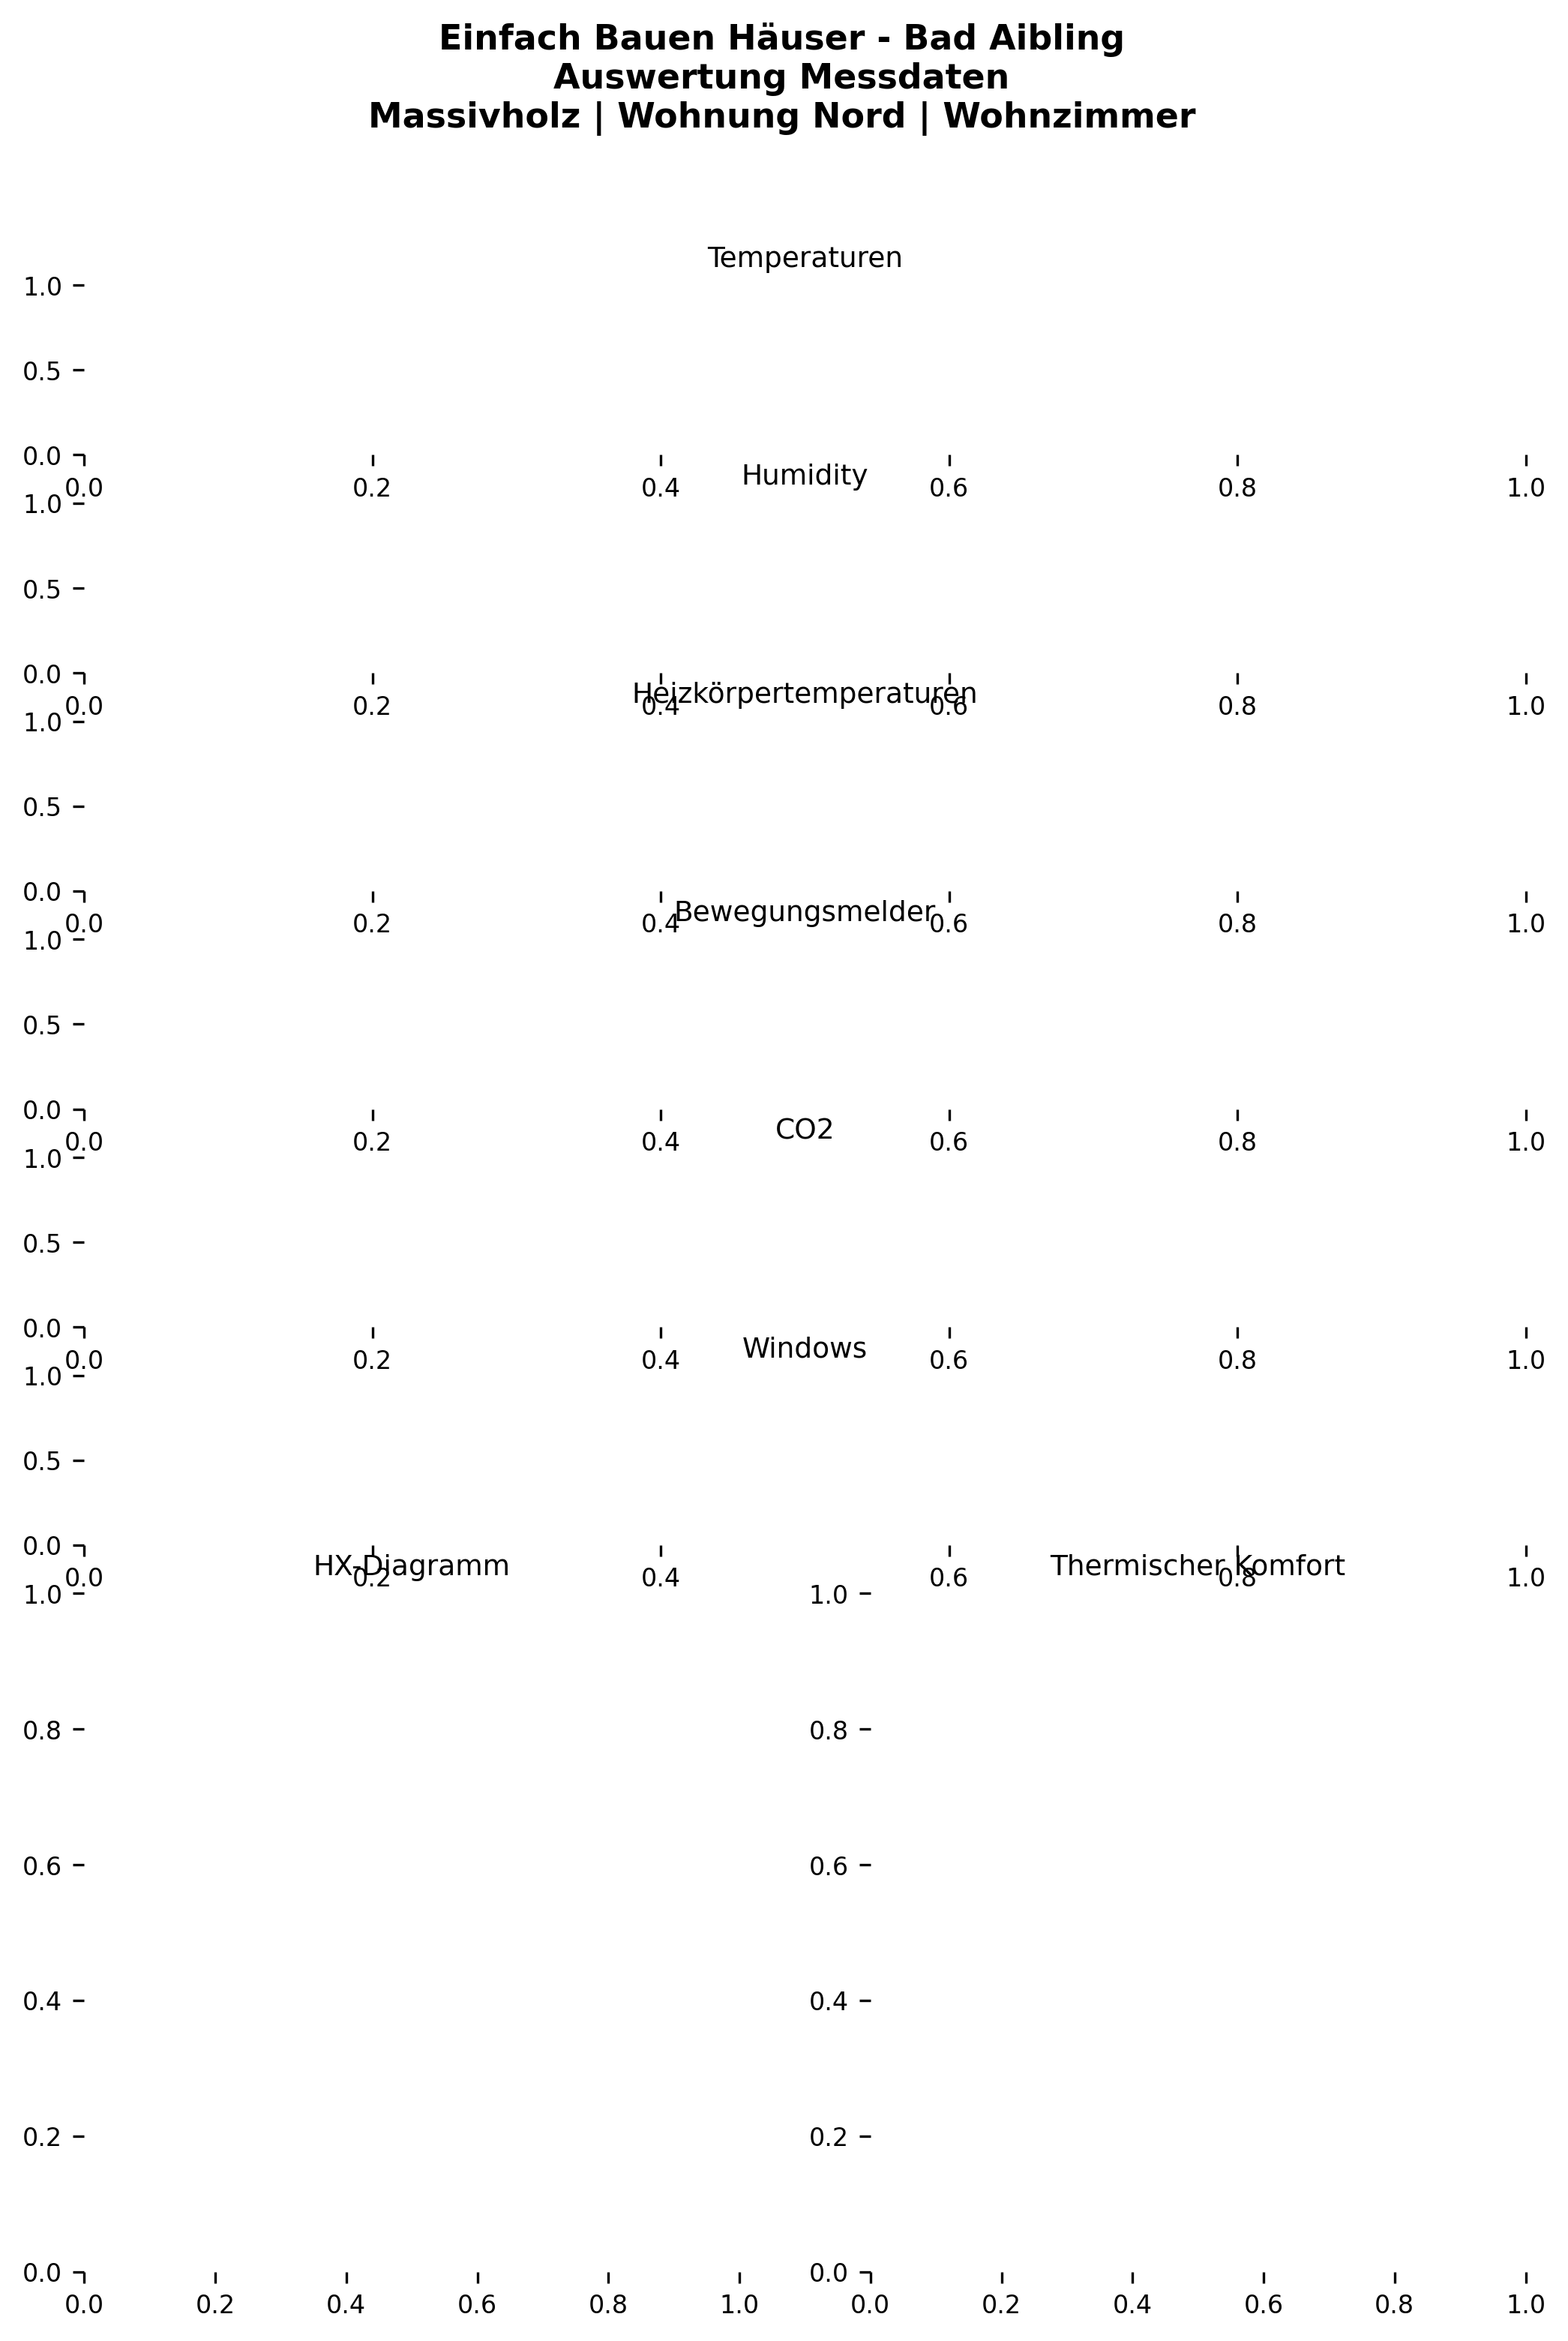

In [120]:
fig

In [ ]:

            axs['Temperature'] = fig.add_subplot(gs[0,:])
            axs['Temperature'].set_title('Temperaturen', fontweight = 'bold')
            axs['Temperature'].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')

            #----#2: Humidity ----

            axs[1] = fig.add_subplot(gs[1,:])
            axs[1].set_title('Luftfeuchten', fontweight = 'bold')
            axs[1].set_ylabel('rel. Luftfeuchte\n[%]', fontweight = 'bold')
            axs[1].set_ylim(0,100)

            #----#3: Heizkörpertemperatur ----
            axs[2] = fig.add_subplot(gs[2,:])
            axs[2].set_title('Heizkörpertemperaturen', fontweight = 'bold')
            axs[2].set_ylabel('Temperatur\n[°C]', fontweight = 'bold')
            axs[2].set_ylim(0,55)


            #----#4: Bewegungsmelder ----
            axs[3] = fig.add_subplot(gs[3,:])
            axs[3].set_title('Bewegungsmelder', fontweight = 'bold')
            axs[3].set_ylabel('Anwesenheit\n[min pro Stunde/Tag]', fontweight = 'bold')

            #----#5: CO2 ----
            axs[4] = fig.add_subplot(gs[4, :])
            axs[4].set_title('CO2 Konzentration in der Raumluft', fontweight = 'bold')
            axs[4].set_ylabel('CO2 Konzentration\n[ppm]', fontweight = 'bold')

            #----#6: Windows ----
            axs[5] = fig.add_subplot(gs[5, :])
            axs[6] = axs[5].twinx()

            axs[5].set_title('Lüftungsverhalten', fontweight = 'bold')
            axs[5].set_ylabel('Fensteröffnung\n[min pro Tag]', fontweight = 'bold')

            axs[6].set_yticks([0,1])
            axs[6].set_yticklabels(['Geschlossen','Geöffnet'])
            axs[6].tick_params(axis = 'y', which='major', length=0)

            for ax in axs[:6]:
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
                ax.xaxis.set_major_locator(mdates.MonthLocator())

            #----#7.1: Thermal Comfort ----
            axs[7] = fig.add_subplot(gs[6, 0])
            axs[8] = fig.add_subplot(gs[6, 1])

            df = ind[app][room]
            for sensor in df.columns:
                if 'trh_Tair' in sensor:
                    Tair = df[sensor]
                    Tamb = amb['T_amb']
                    axs[0].plot(Tair,label = 'Raumlufttemperatur')
                    axs[0].plot(Tamb)

                    eb.recolor_lines(axs[0], eb.c_temp)
                if 'pt_Tsk' in sensor:
                    Tglobe = df[sensor]
                    axs[0].plot(Tglobe,label = 'Globethermometer')

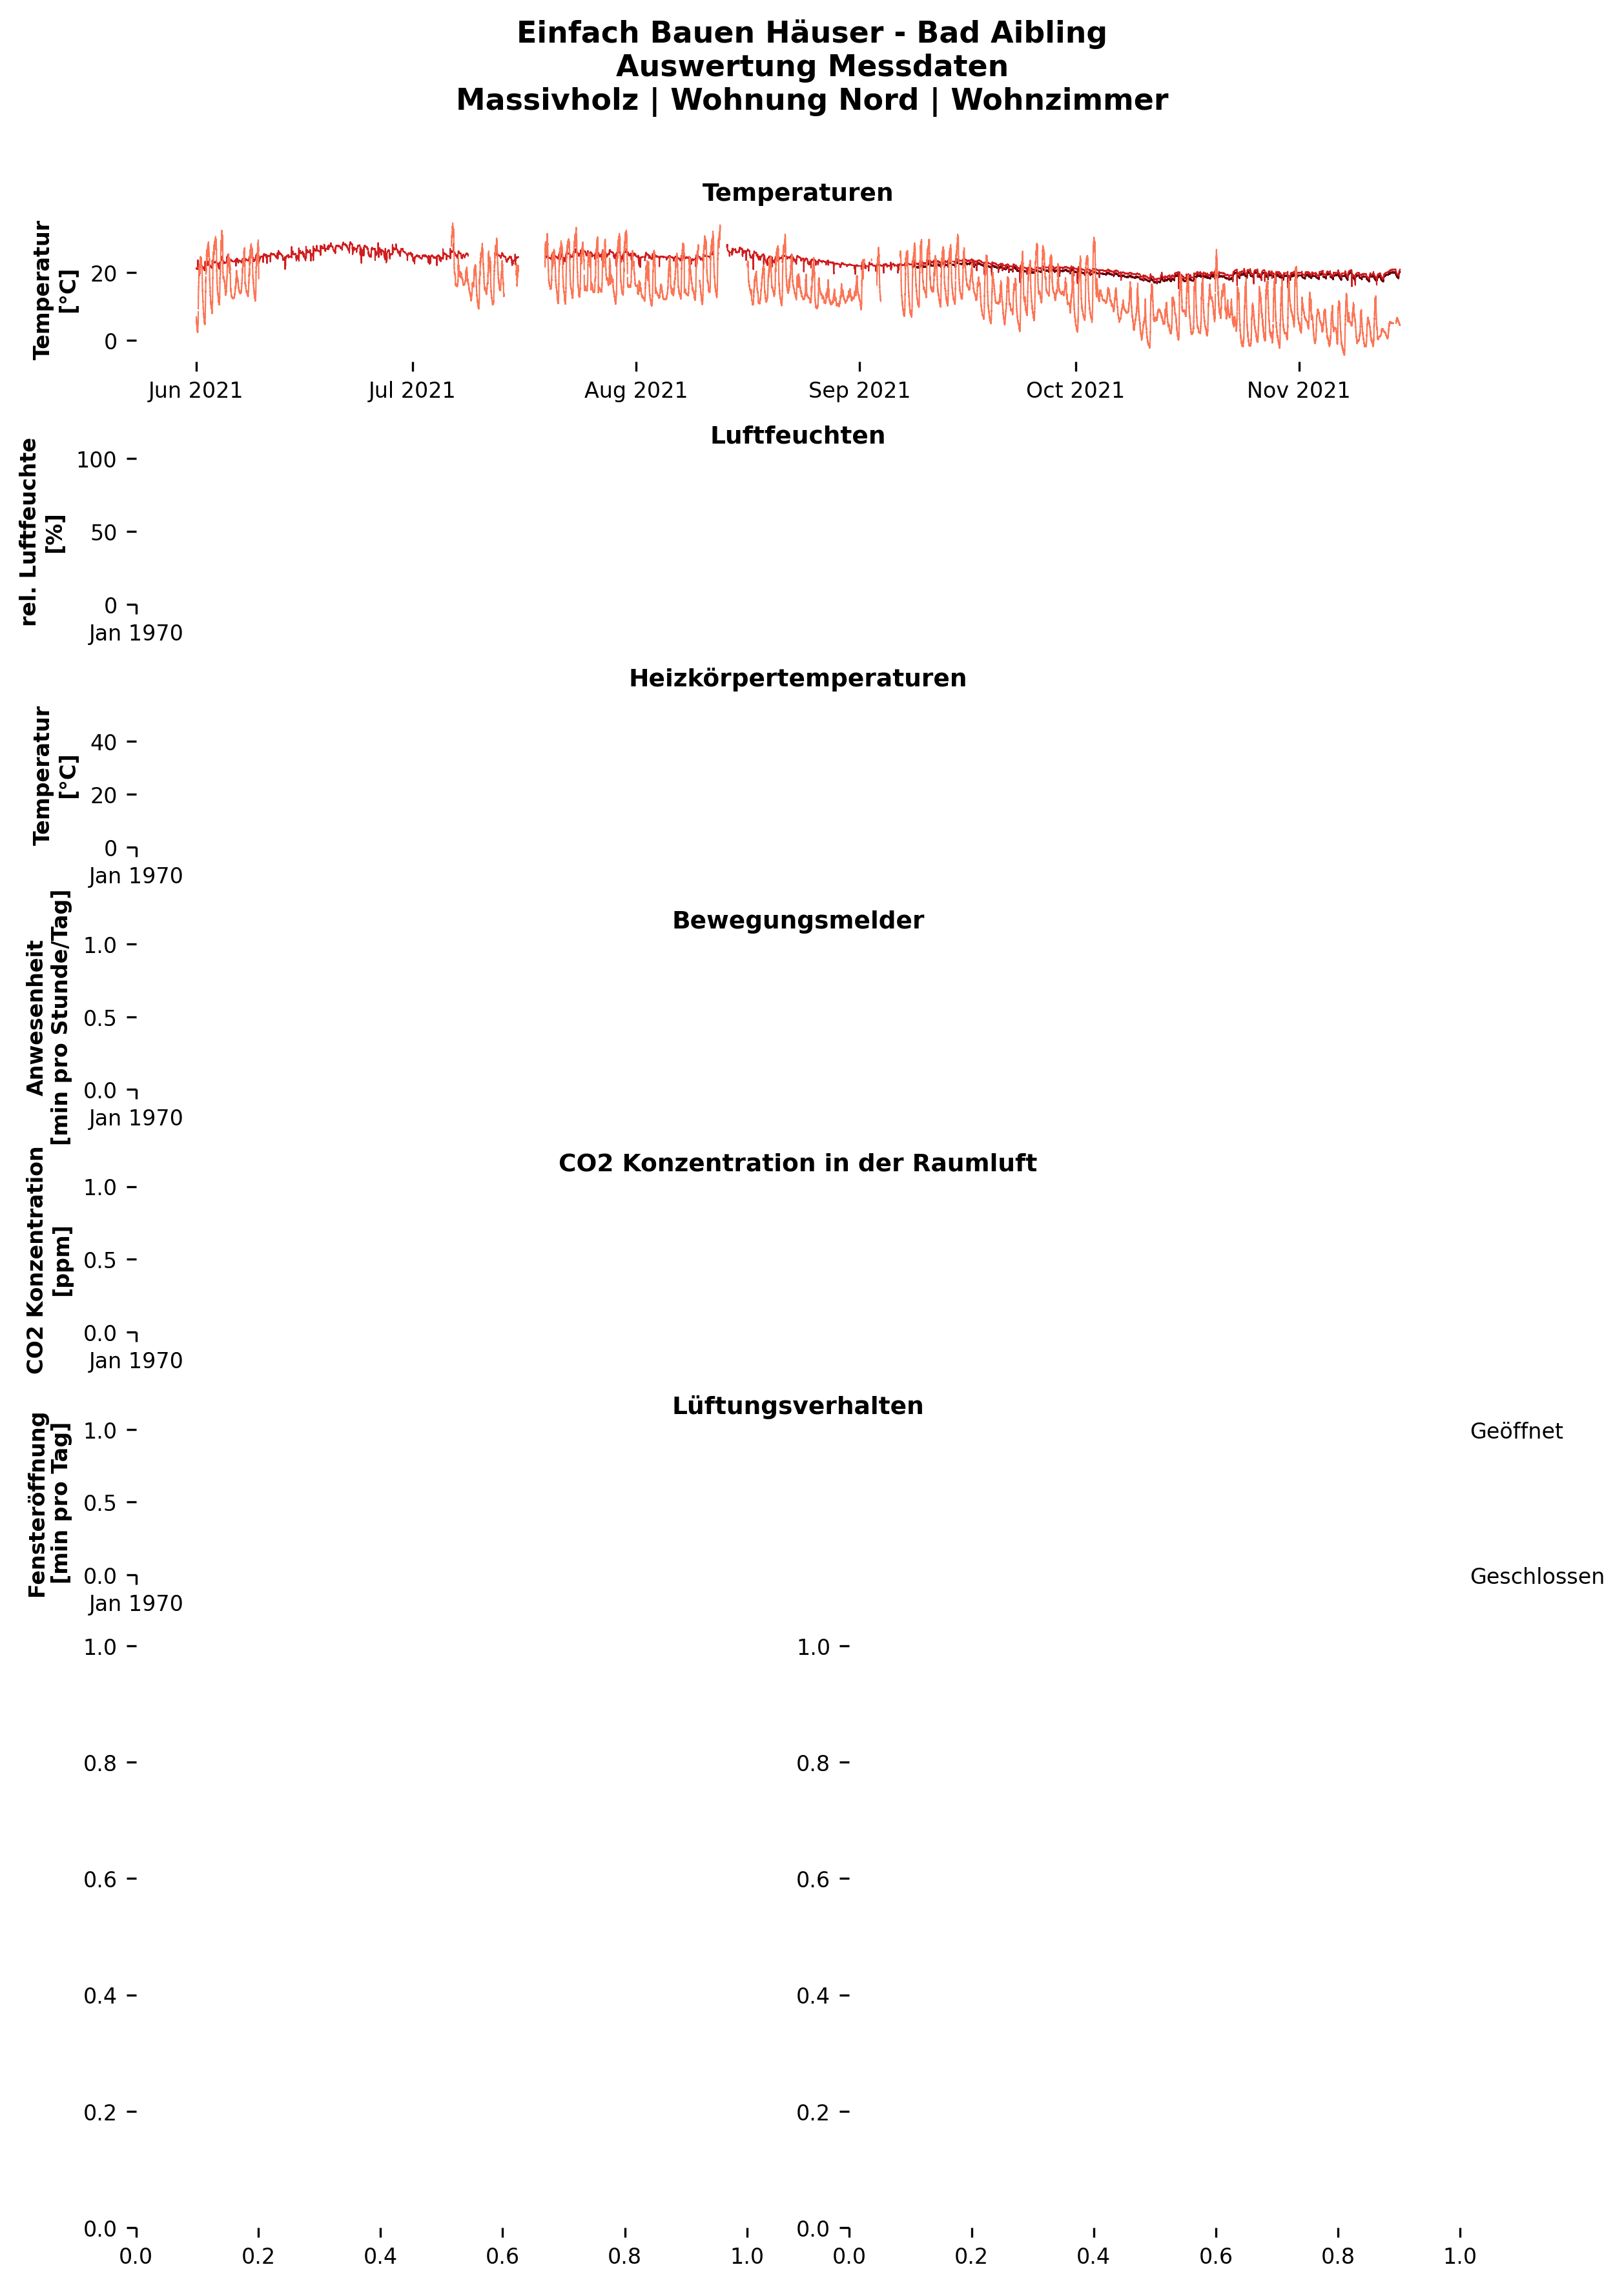

In [73]:
fig

In [ ]:
for sensor in ind[app].columns.get_level_values(level=1):
    names = sensor.split('_',1)
    if len(names) > 1:
        name = names[1]
    


In [37]:
room = 'B'
plots_in_room = []
for bui in eb.buid:
    ind = eb.load_bui(eb.files['tf'][bui]['60min'])
    for app in eb.wohnungen:
        for room in eb.rooms:
            if room in ind[app].columns.get_level_values(level=0).unique():
                for sensor in ind[app][room].columns:
                    if 'trh_Tair' in sensor:
                        print(f'{bui} | {app} | {room} | {sensor}')
                        axs[0].plot(ind[app][room][sensor])

MH | N | B | n_trh_Tair
MH | N | K | w_trh_Tair
MH | N | SZ | n_trh_Tair
MH | N | WZ | s_trh_Tair
MH | S | B | s_trh_Tair
MH | S | K | w_trh_Tair
MH | S | SZ | n_trh_Tair
MH | S | WZ | n_trh_Tair
MH | O | B | n_trh_Tair
MH | O | SWK | m_trh_Tair
MW | N | B | n_trh_Tair
MW | N | K | w_trh_Tair
MW | N | SZ | n_trh_Tair
MW | N | WZ | s_trh_Tair
MW | S | B | s_trh_Tair
MW | S | K | w_trh_Tair
MW | S | SZ | n_trh_Tair
MW | S | WZ | n_trh_Tair
MW | O | B | n_trh_Tair
MW | O | SWK | m_trh_Tair
LB | N | B | n_trh_Tair
LB | N | K | w_trh_Tair
LB | N | SZ | n_trh_Tair
LB | N | WZ | m_trh_Tair
LB | N | WZ | s_trh_Tair
LB | S | B | s_trh_Tair
LB | S | K | w_trh_Tair
LB | S | SZ | n_trh_Tair
LB | S | WZ | n_trh_Tair
LB | O | B | n_trh_Tair
LB | O | SWK | m_trh_Tair


In [ ]:
for app in eb.wohnungen:
    for room in eb.rooms:
        if room in ind[app].columns.get_level_values(level=0).unique():
            
            print(f'{room} exists in {app}')